In [433]:
from IPython import get_ipython
import os
import numpy as np
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
%load_ext autoreload
%autoreload 2

from model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [434]:
#learning parameter
num_epochs = 100
learning_rate = 1e-5


In [435]:
#swissroll parameter
n_samples = 25600
noise = 0.00#0.05
sr, color = make_swiss_roll(n_samples, noise)#sr=swissroll

def custom_loss(output, target, diff_var):
    loss = torch.mean(((output - target)*(1+(diff_var/200000000)))**2)
    return loss


In [436]:
def z_score(x, axis = None):
    xmean = x.mean(axis=axis, keepdims=True)
    xstd = np.std(x, axis=axis, keepdims=True)
    zscore = (x-xmean)/xstd
    return zscore, xmean, xstd

def reverse_z_score(x, input_mean, input_std, axis = None):
    reverse_zscore = (x+input_mean)*input_std
    return reverse_zscore


In [437]:
def plot_swissroll(sr, color):
    if np_sr.shape[1] == 3:
        fig = plt.figure()#図の宣言
        ax = fig.add_subplot(111, projection='3d')#三次元で[1,1,1]の位置にプロット
        ax.scatter(sr[:, 0], sr[:, 1], sr[:, 2], c=color, cmap=plt.cm.Spectral)
    elif np_sr.shape[1] == 2:
        plt.scatter(sr[:, 0], sr[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.xticks([]), plt.yticks([])
    plt.show()

<IPython.core.display.Javascript object>


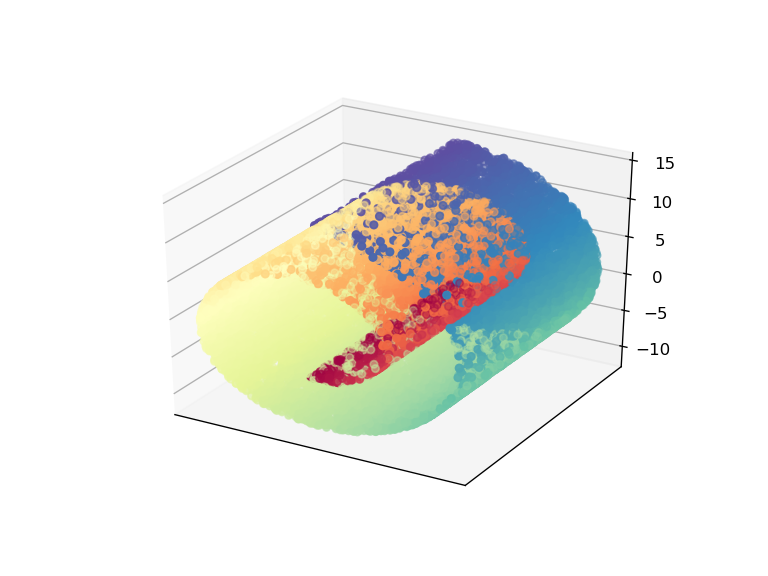

In [438]:
np_sr = np.array(sr)
plot_swissroll(sr, color)

In [439]:
np_sr, input_mean, input_std = z_score(np_sr)#zスコアで標準化
dimension=3#スイスロールは3次元のため一応明示的に書いておく
sr_min=np.amin(np_sr.reshape(n_samples*dimension), axis=0)#clampで標準化してから学習するが、
sr_max=np.amax(np_sr.reshape(n_samples*dimension), axis=0)#最終的に復元するときのために最大最小を保存
print(f'min:{sr_min}, max:{sr_max}')


min:-1.9256287978749203, max:2.1056577071463116


In [440]:
model = autoencoder().cuda()
criterion = custom_loss#nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-6)
# optimizer = torch.optim.SGD(
#     model.parameters(), lr=learning_rate)


In [441]:
in_tensor = torch.from_numpy(np_sr.astype(np.float32))#np_srをテンソルにしたもの
print(f"in_tensor:{in_tensor.size()}")


in_tensor:torch.Size([25600, 3])


In [442]:
for epoch in range(num_epochs):
    for data in DataLoader(in_tensor, batch_size=BATCH_SIZE, shuffle=True):
        batch = data
        batch = batch.reshape(batch.size(0)*3)
        batch = Variable(batch).cuda()
        # ===================forward=====================
        output, diff_var = model(batch)
        loss = criterion(output, batch, diff_var)
        #print(loss)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.data.item()}')
    if epoch % 10 == 0:
        pass#あとで復元がどれくらいできているかここに書いてもいいかも


epoch [1/100], loss:0.9524456858634949
epoch [2/100], loss:0.7877777814865112
epoch [3/100], loss:0.6912269592285156
epoch [4/100], loss:0.6681196093559265
epoch [5/100], loss:0.6855747103691101
epoch [6/100], loss:0.6850161552429199
epoch [7/100], loss:0.6885856986045837
epoch [8/100], loss:0.6727761030197144
epoch [9/100], loss:0.6869868636131287
epoch [10/100], loss:0.692563533782959
epoch [11/100], loss:0.6700824499130249
epoch [12/100], loss:0.6738990545272827
epoch [13/100], loss:0.6523573994636536
epoch [14/100], loss:0.6602545380592346
epoch [15/100], loss:0.6561766862869263
epoch [16/100], loss:0.6956170797348022
epoch [17/100], loss:0.6851797103881836
epoch [18/100], loss:0.6954032778739929
epoch [19/100], loss:0.6378064155578613
epoch [20/100], loss:0.6646842360496521
epoch [21/100], loss:0.6792802214622498
epoch [22/100], loss:0.6722707152366638
epoch [23/100], loss:0.6710400581359863
epoch [24/100], loss:0.6878661513328552
epoch [25/100], loss:0.6828219294548035
epoch [26/

TEST:0
TEST:1
TEST:2
TEST:3
TEST:4
TEST:5
TEST:6
TEST:7
TEST:8
TEST:9
TEST:10
TEST:11
TEST:12
TEST:13
TEST:14
TEST:15
TEST:16
TEST:17
TEST:18
TEST:19
TEST:20
TEST:21
TEST:22
TEST:23
TEST:24
TEST:25
TEST:26
TEST:27
TEST:28
TEST:29
TEST:30
TEST:31
TEST:32
TEST:33
TEST:34
TEST:35
TEST:36
TEST:37
TEST:38
TEST:39
TEST:40
TEST:41
TEST:42
TEST:43
TEST:44
TEST:45
TEST:46
TEST:47
TEST:48
TEST:49


<IPython.core.display.Javascript object>


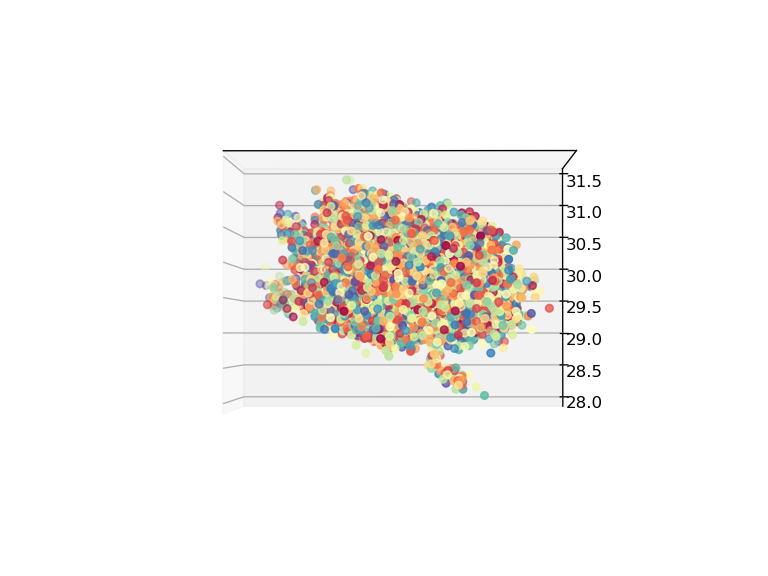

In [443]:
result=np.empty((0,3))
for n, data in enumerate(DataLoader(in_tensor, batch_size=BATCH_SIZE, shuffle=False)):#シャッフルしない
    print(f'TEST:{n}')
    batch = data
    batch = batch.reshape(batch.size(0)*3)
    batch = Variable(batch).cuda()
    # ===================forward=====================
    output, _ = model(batch)
    result=np.vstack([result, output.data.cpu().numpy().reshape(BATCH_SIZE, INPUT_AXIS)])
    
plot_swissroll(reverse_z_score(result, input_mean, input_std), color)

# loss the Variable,
# loss.data the (presumably size 1) Tensor,
# loss.data[0] the (python) float at position 0 in the tensor.
torch.save(model.state_dict(), './sim_autoencoder.pth')
